# Insurance cost prediction using linear regression

Make a submisson here: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/assignment-2-train-your-first-model

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lessons. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ai/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ai/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ai/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [ ]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [ ]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [ ]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [ ]:
your_name = 'lawrence' # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [ ]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [ ]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
469,18,female,23.36730,1,no,southeast,2619.305549
82,22,male,36.49140,1,yes,southeast,44226.544922
517,45,male,29.58015,2,no,northwest,10012.021030
499,62,female,38.02400,0,no,southwest,16030.323400
48,60,female,23.79410,0,no,southeast,15029.577073


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [ ]:
num_rows = len(dataframe.index)
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [ ]:
num_cols = dataframe.shape[1]
print(num_cols)

7


**Q: What are the column titles of the input variables?**

In [ ]:
input_cols = [i for i in dataframe.columns[:-1]]
#list from age to region
input_cols

['age', 'sex', 'bmi', 'children', 'smoker', 'region']

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [ ]:
categorical_cols = [i for i in dataframe.select_dtypes(exclude=['number']).columns]
categorical_cols

['sex', 'smoker', 'region']

**Q: What are the column titles of output/target variable(s)?**

In [ ]:
output_cols = [dataframe.columns[-1]]
output_cols

['charges']

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

In [ ]:
print("Minimum value : {} ".format(dataframe['charges'].min()))
print("Maximum value : {} ".format(dataframe['charges'].max()))
print("Average value :: {} ".format(dataframe['charges'].mean()))

Minimum value : 1335.029941 
Maximum value : 75886.8093319 
Average value :: 15828.656992017379 


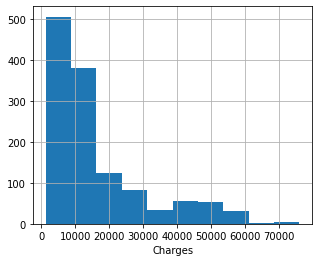

In [ ]:
%matplotlib inline

plt.figure(figsize=(5,4))
plt.hist(dataframe.charges)
plt.grid()
plt.xlabel("Charges");

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


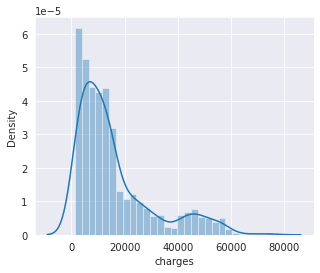

In [ ]:
import seaborn as sns

sns.set_style("darkgrid")

plt.figure(figsize=(5,4))
sns.distplot(dataframe.charges, kde=True);

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [ ]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [ ]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[18.     ,  0.     , 23.3673 ,  1.     ,  0.     ,  2.     ],
        [22.     ,  1.     , 36.4914 ,  1.     ,  1.     ,  2.     ],
        [45.     ,  1.     , 29.58015,  2.     ,  0.     ,  1.     ],
        ...,
        [26.     ,  0.     , 33.174  ,  2.     ,  0.     ,  3.     ],
        [23.     ,  1.     , 31.5832 ,  0.     ,  0.     ,  2.     ],
        [31.     ,  0.     , 25.026  ,  2.     ,  0.     ,  3.     ]]),
 array([[ 2619.305549 ],
        [44226.544922 ],
        [10012.0210295],
        ...,
        [ 4745.63194  ],
        [ 2170.899626 ],
        [ 5872.29895  ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [ ]:
inputs = torch.from_numpy(inputs_array).float()
targets = torch.from_numpy(targets_array).float()

In [ ]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [ ]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [ ]:
val_percent = 0.1 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [ ]:
batch_size = 128

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [ ]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[61.0000,  1.0000, 37.2286,  0.0000,  0.0000,  1.0000],
        [61.0000,  0.0000, 37.9270,  2.0000,  0.0000,  3.0000],
        [41.0000,  0.0000, 27.2085,  1.0000,  0.0000,  2.0000],
        [50.0000,  1.0000, 31.1467,  2.0000,  0.0000,  0.0000],
        [46.0000,  0.0000, 29.8760,  3.0000,  0.0000,  3.0000],
        [39.0000,  0.0000, 33.0770,  3.0000,  0.0000,  3.0000],
        [52.0000,  0.0000, 22.4846,  0.0000,  0.0000,  0.0000],
        [51.0000,  0.0000, 25.0260,  1.0000,  0.0000,  3.0000],
        [19.0000,  0.0000, 23.8668,  1.0000,  0.0000,  1.0000],
        [19.0000,  1.0000, 24.4198,  0.0000,  0.0000,  1.0000],
        [42.0000,  1.0000, 25.5256,  1.0000,  0.0000,  1.0000],
        [35.0000,  1.0000, 33.7269,  2.0000,  0.0000,  1.0000],
        [60.0000,  0.0000, 29.5850,  0.0000,  0.0000,  3.0000],
        [48.0000,  1.0000, 28.7120,  0.0000,  0.0000,  3.0000],
        [51.0000,  1.0000, 31.3310,  1.0000,  0.0000,  0.0000],
        [44.0000,  0.0000, 37.78

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [ ]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [ ]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)  # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)    # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)    # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [ ]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0568,  0.2454, -0.3191,  0.1978, -0.3161,  0.1013]],
        requires_grad=True), Parameter containing:
 tensor([0.0274], requires_grad=True)]

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [ ]:
result = evaluate(model,val_loader) # Use the the evaluate function
print(result)

{'val_loss': 14403.748046875}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [ ]:
epochs = 500
lr = 5e-1
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6292.1191
Epoch [40], val_loss: 6246.1021
Epoch [60], val_loss: 6263.2314
Epoch [80], val_loss: 6218.1035
Epoch [100], val_loss: 6220.0010
Epoch [120], val_loss: 6227.4849
Epoch [140], val_loss: 6185.6182
Epoch [160], val_loss: 6175.2554
Epoch [180], val_loss: 6175.2275
Epoch [200], val_loss: 6171.0410
Epoch [220], val_loss: 6180.6406
Epoch [240], val_loss: 6166.2295
Epoch [260], val_loss: 6144.6890
Epoch [280], val_loss: 6126.6318
Epoch [300], val_loss: 6139.1929
Epoch [320], val_loss: 6128.3052
Epoch [340], val_loss: 6129.2349
Epoch [360], val_loss: 6097.0537
Epoch [380], val_loss: 6100.3662
Epoch [400], val_loss: 6082.9365
Epoch [420], val_loss: 6101.5508
Epoch [440], val_loss: 6076.3389
Epoch [460], val_loss: 6086.3306
Epoch [480], val_loss: 6070.7451
Epoch [500], val_loss: 6057.4238


In [ ]:
epochs = 500
lr = 5e-1
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5946.3140
Epoch [40], val_loss: 5945.2104
Epoch [60], val_loss: 5938.5830
Epoch [80], val_loss: 5953.7910
Epoch [100], val_loss: 5937.7793
Epoch [120], val_loss: 5952.2661
Epoch [140], val_loss: 5922.8525
Epoch [160], val_loss: 5920.1919
Epoch [180], val_loss: 5954.3433
Epoch [200], val_loss: 5934.0439
Epoch [220], val_loss: 5909.8218
Epoch [240], val_loss: 5913.5942
Epoch [260], val_loss: 5902.6831
Epoch [280], val_loss: 5927.3994
Epoch [300], val_loss: 5897.5205
Epoch [320], val_loss: 5889.8384
Epoch [340], val_loss: 5890.1582
Epoch [360], val_loss: 5884.9971
Epoch [380], val_loss: 5883.9312
Epoch [400], val_loss: 5882.8271
Epoch [420], val_loss: 5888.9614
Epoch [440], val_loss: 5908.4971
Epoch [460], val_loss: 5865.1025
Epoch [480], val_loss: 5860.0366
Epoch [500], val_loss: 5856.4717


In [ ]:
epochs = 1000
lr = 5e-1
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5872.4785
Epoch [40], val_loss: 5851.9141
Epoch [60], val_loss: 5847.5967
Epoch [80], val_loss: 5852.0317
Epoch [100], val_loss: 5849.3389
Epoch [120], val_loss: 5878.2246
Epoch [140], val_loss: 5837.0522
Epoch [160], val_loss: 5827.5444
Epoch [180], val_loss: 5829.2124
Epoch [200], val_loss: 5835.4033
Epoch [220], val_loss: 5821.9937
Epoch [240], val_loss: 5818.8950
Epoch [260], val_loss: 5852.5991
Epoch [280], val_loss: 5811.5044
Epoch [300], val_loss: 5803.9502
Epoch [320], val_loss: 5798.8081
Epoch [340], val_loss: 5797.1484
Epoch [360], val_loss: 5805.6616
Epoch [380], val_loss: 5808.1182
Epoch [400], val_loss: 5785.2427
Epoch [420], val_loss: 5787.1035
Epoch [440], val_loss: 5801.2661
Epoch [460], val_loss: 5774.5415
Epoch [480], val_loss: 5793.1401
Epoch [500], val_loss: 5793.8335
Epoch [520], val_loss: 5765.9375
Epoch [540], val_loss: 5763.1626
Epoch [560], val_loss: 5757.2134
Epoch [580], val_loss: 5758.9297
Epoch [600], val_loss: 5758.3896
Epoch [620], v

In [ ]:
epochs = 1000
lr = 2e-1
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5676.9888
Epoch [40], val_loss: 5683.3267
Epoch [60], val_loss: 5675.7676
Epoch [80], val_loss: 5673.4443
Epoch [100], val_loss: 5672.1006
Epoch [120], val_loss: 5670.0117
Epoch [140], val_loss: 5668.9683
Epoch [160], val_loss: 5669.0112
Epoch [180], val_loss: 5669.4038
Epoch [200], val_loss: 5664.4473
Epoch [220], val_loss: 5666.1489
Epoch [240], val_loss: 5663.9722
Epoch [260], val_loss: 5662.6626
Epoch [280], val_loss: 5663.9976
Epoch [300], val_loss: 5662.4526
Epoch [320], val_loss: 5657.5283
Epoch [340], val_loss: 5657.7236
Epoch [360], val_loss: 5655.4346
Epoch [380], val_loss: 5654.4390
Epoch [400], val_loss: 5652.0366
Epoch [420], val_loss: 5649.1846
Epoch [440], val_loss: 5649.1221
Epoch [460], val_loss: 5646.5796
Epoch [480], val_loss: 5645.0107
Epoch [500], val_loss: 5645.5771
Epoch [520], val_loss: 5643.1675
Epoch [540], val_loss: 5640.9414
Epoch [560], val_loss: 5642.3252
Epoch [580], val_loss: 5638.0947
Epoch [600], val_loss: 5640.4346
Epoch [620], v

In [ ]:
epochs = 5000
lr = 1e-1
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5591.8652
Epoch [40], val_loss: 5590.4897
Epoch [60], val_loss: 5589.7314
Epoch [80], val_loss: 5589.4492
Epoch [100], val_loss: 5588.7500
Epoch [120], val_loss: 5587.7422
Epoch [140], val_loss: 5588.3467
Epoch [160], val_loss: 5586.7183
Epoch [180], val_loss: 5585.6260
Epoch [200], val_loss: 5584.9683
Epoch [220], val_loss: 5584.4590
Epoch [240], val_loss: 5583.9844
Epoch [260], val_loss: 5582.7432
Epoch [280], val_loss: 5582.0469
Epoch [300], val_loss: 5581.2935
Epoch [320], val_loss: 5580.6318
Epoch [340], val_loss: 5580.6519
Epoch [360], val_loss: 5579.2446
Epoch [380], val_loss: 5578.9751
Epoch [400], val_loss: 5578.8472
Epoch [420], val_loss: 5577.5420
Epoch [440], val_loss: 5576.7329
Epoch [460], val_loss: 5576.2954
Epoch [480], val_loss: 5575.9116
Epoch [500], val_loss: 5574.4863
Epoch [520], val_loss: 5574.1924
Epoch [540], val_loss: 5573.3027
Epoch [560], val_loss: 5572.8062
Epoch [580], val_loss: 5571.8911
Epoch [600], val_loss: 5572.1719
Epoch [620], v

In [ ]:
epochs = 5000
lr = 1e-1
history6 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5420.3628
Epoch [40], val_loss: 5419.2979
Epoch [60], val_loss: 5418.1260
Epoch [80], val_loss: 5417.7817
Epoch [100], val_loss: 5416.7739
Epoch [120], val_loss: 5416.9185
Epoch [140], val_loss: 5414.9712
Epoch [160], val_loss: 5414.3643
Epoch [180], val_loss: 5413.9771
Epoch [200], val_loss: 5413.8076
Epoch [220], val_loss: 5412.5186
Epoch [240], val_loss: 5412.9238
Epoch [260], val_loss: 5410.9629
Epoch [280], val_loss: 5411.1831
Epoch [300], val_loss: 5410.9209
Epoch [320], val_loss: 5410.2036
Epoch [340], val_loss: 5408.2661
Epoch [360], val_loss: 5408.8760
Epoch [380], val_loss: 5407.9199
Epoch [400], val_loss: 5406.6206
Epoch [420], val_loss: 5405.5200
Epoch [440], val_loss: 5405.1279
Epoch [460], val_loss: 5404.1250
Epoch [480], val_loss: 5403.3125
Epoch [500], val_loss: 5406.1040
Epoch [520], val_loss: 5403.4639
Epoch [540], val_loss: 5401.4023
Epoch [560], val_loss: 5400.9126
Epoch [580], val_loss: 5401.1143
Epoch [600], val_loss: 5399.5093
Epoch [620], v

In [ ]:
epochs = 5000
lr = 1e-2
history7 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5250.3418
Epoch [40], val_loss: 5250.2734
Epoch [60], val_loss: 5250.1948
Epoch [80], val_loss: 5250.0156
Epoch [100], val_loss: 5249.9673
Epoch [120], val_loss: 5249.9292
Epoch [140], val_loss: 5249.8081
Epoch [160], val_loss: 5249.7207
Epoch [180], val_loss: 5249.7358
Epoch [200], val_loss: 5249.5371
Epoch [220], val_loss: 5249.5601
Epoch [240], val_loss: 5249.5840
Epoch [260], val_loss: 5249.4385
Epoch [280], val_loss: 5249.3247
Epoch [300], val_loss: 5249.3394
Epoch [320], val_loss: 5249.2026
Epoch [340], val_loss: 5249.1812
Epoch [360], val_loss: 5249.0713
Epoch [380], val_loss: 5249.1338
Epoch [400], val_loss: 5248.9595
Epoch [420], val_loss: 5248.8589
Epoch [440], val_loss: 5248.8149
Epoch [460], val_loss: 5248.7598
Epoch [480], val_loss: 5248.6118
Epoch [500], val_loss: 5248.4985
Epoch [520], val_loss: 5248.5352
Epoch [540], val_loss: 5248.4609
Epoch [560], val_loss: 5248.4526
Epoch [580], val_loss: 5248.3091
Epoch [600], val_loss: 5248.2280
Epoch [620], v

**Q: What is the final validation loss of your model?**

In [ ]:
val_loss = 5233.5122

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [ ]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)        # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [ ]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([32.0000,  1.0000, 32.8054,  1.0000,  0.0000,  1.0000])
Target: tensor([5310.6392])
Prediction: tensor([6188.1406])


In [ ]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([24.0000,  1.0000, 38.9455,  0.0000,  1.0000,  2.0000])
Target: tensor([45370.2344])
Prediction: tensor([7444.4590])


In [ ]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([64.0000,  0.0000, 29.2115,  3.0000,  0.0000,  1.0000])
Target: tensor([19582.2930])
Prediction: tensor([17705.7227])


Are you happy with your model's predictions? Try to improve them further.